# Duration for Food Delivery Door Dash Application 
This notebook focuses on the delivery time for orders on the DoorDash Application from data found on Stratscratch to help data scientists with expected interview questions from top companies such as DoorDash. 

* **Importing Library**
* **Loading data**
* **Data Preprocessing & Visualization**
* **Model Building**
  

## Import Libraries

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn import preprocessing

my_file = Path("historical_data.csv")

## Loading Data
  
  **About the data:**
The attached file historical_data.csv contains a subset of deliveries received at DoorDash in early 2015 in a subset of the cities. Each row in this file corresponds to one unique delivery. We have added noise to the dataset to obfuscate certain business details. Each column corresponds to a feature as explained below. Note all money (dollar) values given in the data are in cents and all time duration values given are in seconds

The target value to predict here is the total seconds value between created_at and actual_delivery_time.

**Time features**

* market_id: A city/region in which DoorDash operates, e.g., Los Angeles, given in the data as an id
* created_at: Timestamp in UTC when the order was submitted by the consumer to DoorDash. (Note this timestamp is in UTC, but in case you need it, the actual timezone of the region was US/Pacific)
* actual_delivery_time: Timestamp in UTC when the order was delivered to the consumer

**Store features**

* store_id: an id representing the restaurant the order was submitted for
* store_primary_category: cuisine category of the restaurant, e.g., italian, asian
* order_protocol: a store can receive orders from DoorDash through many modes. This field represents an id denoting the protocol

**Order features**

* total_items: total number of items in the order
* subtotal: total value of the order submitted (in cents)
* num_distinct_items: number of distinct items included in the order
* min_item_price: price of the item with the least cost in the order (in cents)
* max_item_price: price of the item with the highest cost in the order (in cents)

**Market features**

DoorDash being a marketplace, we have information on the state of marketplace when the order is placed, that can be used to estimate delivery time. The following features are values at the time of created_at (order submission time):

* total_onshift_dashers: Number of available dashers who are within 10 miles of the store at the time of order creation
* total_busy_dashers: Subset of above total_onshift_dashers who are currently working on an order
* total_outstanding_orders: Number of orders within 10 miles of this order that are currently being processed.
Predictions from other models

**We have predictions from other models for various stages of delivery process that we can use:**

* estimated_order_place_duration: Estimated time for the restaurant to receive the order from DoorDash (in seconds)
* estimated_store_to_consumer_driving_duration: Estimated travel time between store and consumer (in seconds)

Note:This Description belongs to the dataset source found [here](https://platform.stratascratch.com/data-projects/delivery-duration-prediction)


## Data Preprocessing & Visualization

In [16]:
dash=pd.read_csv('historical_data.csv')
dash.head()

,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration
0,1.0,2015-02-06 22:24:17,2015-02-06 23:27:16,1845,american,1.0,4,3441,4,557,1239,33.0,14.0,21.0,446,861.0
1,2.0,2015-02-10 21:49:25,2015-02-10 22:56:29,5477,mexican,2.0,1,1900,1,1400,1400,1.0,2.0,2.0,446,690.0
2,3.0,2015-01-22 20:39:28,2015-01-22 21:09:09,5477,NaN,1.0,1,1900,1,1900,1900,1.0,0.0,0.0,446,690.0
3,3.0,2015-02-03 21:21:45,2015-02-03 22:13:00,5477,NaN,1.0,6,6900,5,600,1800,1.0,1.0,2.0,446,289.0
4,3.0,2015-02-15 02:40:36,2015-02-15 03:20:26,5477,NaN,1.0,3,3900,3,1100,1600,6.0,6.0,9.0,446,650.0


In [17]:
dash.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197428 entries, 0 to 197427
Data columns (total 16 columns):
 #   Column                                        Non-Null Count   Dtype  
---  ------                                        --------------   -----  
 0   market_id                                     196441 non-null  float64
 1   created_at                                    197428 non-null  object 
 2   actual_delivery_time                          197421 non-null  object 
 3   store_id                                      197428 non-null  int64  
 4   store_primary_category                        192668 non-null  object 
 5   order_protocol                                196433 non-null  float64
 6   total_items                                   197428 non-null  int64  
 7   subtotal                                      197428 non-null  int64  
 8   num_distinct_items                            197428 non-null  int64  
 9   min_item_price                                19

In [18]:
dash.describe()

,market_id,store_id,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration
count,196441.000000,197428.000000,196433.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,181166.000000,181166.000000,181166.000000,197428.000000,196902.000000
mean,2.978706,3530.510272,2.882352,3.196391,2682.331402,2.670791,686.218470,1159.588630,44.808093,41.739747,58.050065,308.560179,545.358935
std,1.524867,2053.496711,1.503771,2.666546,1823.093688,1.630255,522.038648,558.411377,34.526783,32.145733,52.661830,90.139653,219.352902
min,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,-86.000000,0.000000,-4.000000,-5.000000,-6.000000,0.000000,0.000000
25%,2.000000,1686.000000,1.000000,2.000000,1400.000000,1.000000,299.000000,800.000000,17.000000,15.000000,17.000000,251.000000,382.000000
50%,3.000000,3592.000000,3.000000,3.000000,2200.000000,2.000000,595.000000,1095.000000,37.000000,34.000000,41.000000,251.000000,544.000000
75%,4.000000,5299.000000,4.000000,4.000000,3395.000000,3.000000,949.000000,1395.000000,65.000000,62.000000,85.000000,446.000000,702.000000
max,6.000000,6987.000000,7.000000,411.000000,27100.000000,20.000000,14700.000000,14700.000000,171.000000,154.000000,285.000000,2715.000000,2088.000000


In [19]:
dash.nunique()

market_id                                            6
created_at                                      180985
actual_delivery_time                            178110
store_id                                          6743
store_primary_category                              74
order_protocol                                       7
total_items                                         57
subtotal                                          8368
num_distinct_items                                  20
min_item_price                                    2312
max_item_price                                    2652
total_onshift_dashers                              172
total_busy_dashers                                 159
total_outstanding_orders                           281
estimated_order_place_duration                      98
estimated_store_to_consumer_driving_duration      1336
dtype: int64

In [20]:
drop_dash=dash.copy()
import datetime as dt

In [21]:
drop_dash['created_at']=drop_dash['created_at'].astype('datetime64[ns]')
drop_dash['actual_delivery_time']=drop_dash['actual_delivery_time'].astype('datetime64[ns]')

In [22]:
drop_dash['created_at'].describe()

count                           197428
mean     2015-02-04 22:00:09.537962752
min                2014-10-19 05:24:15
25%                2015-01-29 02:32:42
50%         2015-02-05 03:29:09.500000
75%         2015-02-12 01:39:18.500000
max                2015-02-18 06:00:44
Name: created_at, dtype: object

In [23]:
dlv_time=drop_dash['actual_delivery_time']-drop_dash['created_at']
drop_dash['delivery_time']=dlv_time.dt.seconds

In [24]:
drop_dash['delivery_time'].mean()/60

47.705080259952084

**Average Delivery Time for orders is ~47 Minutes**

In [25]:
drop_dash.isnull().sum()

market_id                                         987
created_at                                          0
actual_delivery_time                                7
store_id                                            0
store_primary_category                           4760
order_protocol                                    995
total_items                                         0
subtotal                                            0
num_distinct_items                                  0
min_item_price                                      0
max_item_price                                      0
total_onshift_dashers                           16262
total_busy_dashers                              16262
total_outstanding_orders                        16262
estimated_order_place_duration                      0
estimated_store_to_consumer_driving_duration      526
delivery_time                                       7
dtype: int64

In [26]:
missing=(drop_dash.isnull().sum().sum()/np.product(drop_dash.shape) ) * 100
print('Data Missing: ',missing,'%')

Data Missing:  1.6705419935666792 %


In [27]:
print('{0} rows would be dropped if we delete rows with missing values out of {1} rows which is {2} % of the data'.format(drop_dash.shape[0] - drop_dash.dropna().shape[0],drop_dash.shape[0],(drop_dash.shape[0] - drop_dash.dropna().shape[0])/drop_dash.shape[0] * 100))

21651 rows would be dropped if we delete rows with missing values out of 197428 rows which is 10.96652957027372 % of the data


In [28]:
drop_dash=drop_dash.dropna(axis=0)

array([[<Axes: title={'center': 'market_id'}>,
        <Axes: title={'center': 'created_at'}>,
        <Axes: title={'center': 'actual_delivery_time'}>,
        <Axes: title={'center': 'store_id'}>],
       [<Axes: title={'center': 'order_protocol'}>,
        <Axes: title={'center': 'total_items'}>,
        <Axes: title={'center': 'subtotal'}>,
        <Axes: title={'center': 'num_distinct_items'}>],
       [<Axes: title={'center': 'min_item_price'}>,
        <Axes: title={'center': 'max_item_price'}>,
        <Axes: title={'center': 'total_onshift_dashers'}>,
        <Axes: title={'center': 'total_busy_dashers'}>],
       [<Axes: title={'center': 'total_outstanding_orders'}>,
        <Axes: title={'center': 'estimated_order_place_duration'}>,
        <Axes: title={'center': 'estimated_store_to_consumer_driving_duration'}>,
        <Axes: title={'center': 'delivery_time'}>]], dtype=object)

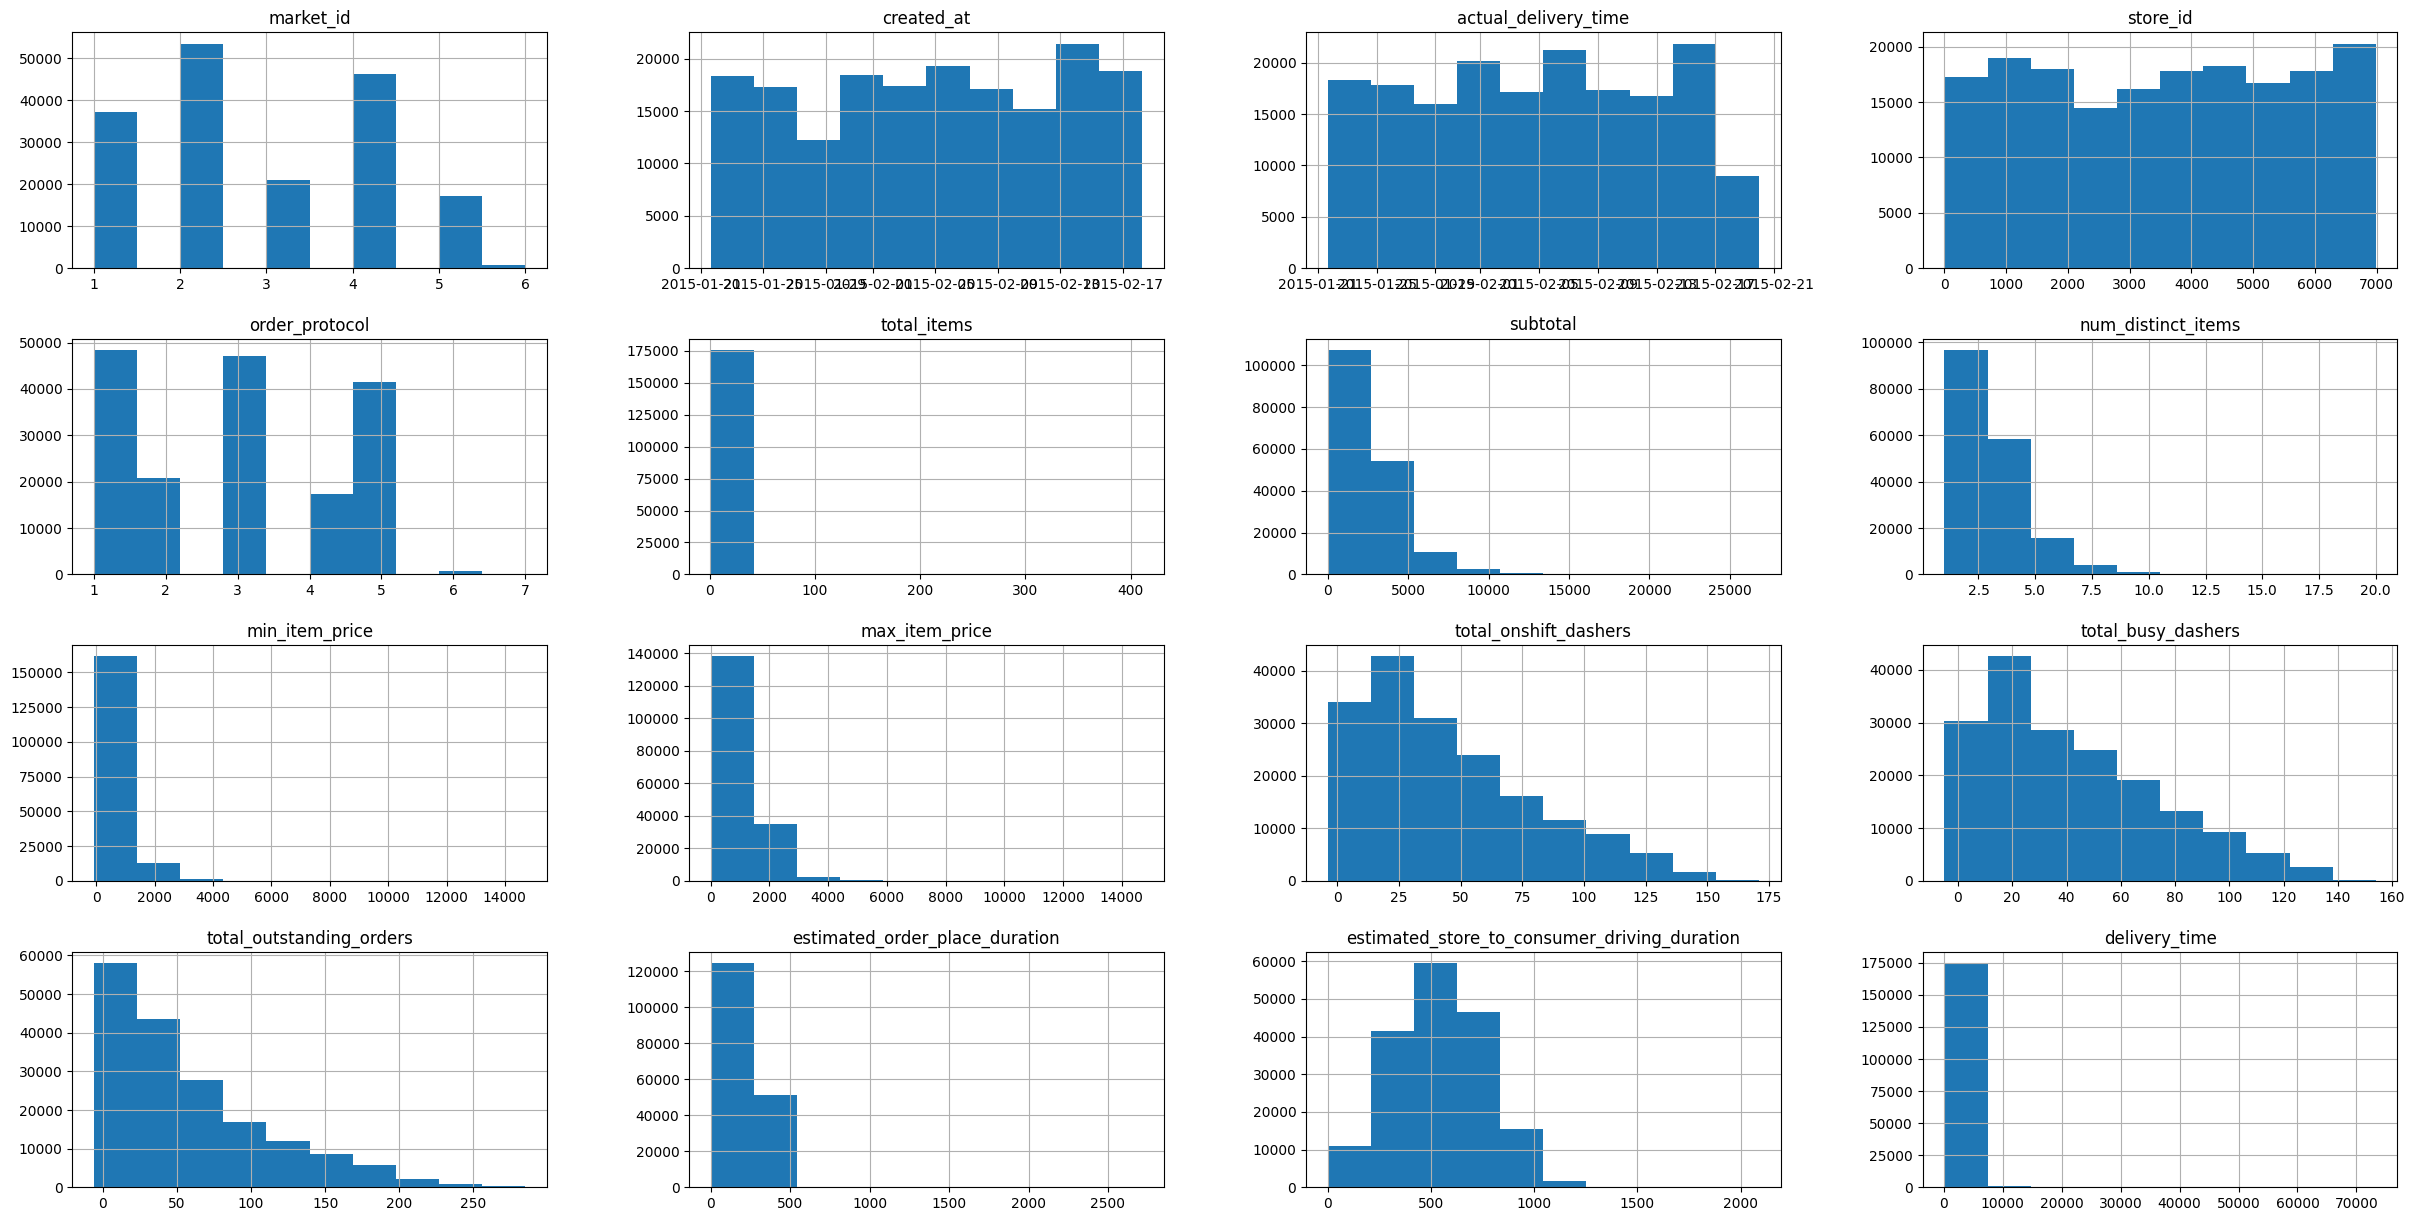

In [29]:
drop_dash.hist(figsize=(30,15))

**Histograms tell more on Column distribution,outlier existence and column value range**


---

We can obviously see outliers in various columns like total_items and min_item_price etc. which is better to check and perhaps remove to get better averaging and overview of the column and data


---

We can observe skewness in various columns aswell like total_busy_dashers and total_outstanding_orders etc.

In [30]:
drop_dash2=drop_dash.copy()

In [31]:
outlier_cols=['total_items','max_item_price','delivery_time','estimated_order_place_duration','min_item_price','num_distinct_items','estimated_store_to_consumer_driving_duration']
drop_dash2[outlier_cols].describe()

,total_items,max_item_price,delivery_time,estimated_order_place_duration,min_item_price,num_distinct_items,estimated_store_to_consumer_driving_duration
count,175777.000000,175777.000000,175777.000000,175777.000000,175777.000000,175777.000000,175777.000000
mean,3.204976,1160.158616,2862.981949,307.818105,684.965433,2.675060,546.077240
std,2.674055,560.828571,1178.445769,89.796587,519.882924,1.625681,218.717798
min,1.000000,0.000000,101.000000,0.000000,-86.000000,1.000000,0.000000
25%,2.000000,799.000000,2105.000000,251.000000,299.000000,1.000000,384.000000
50%,3.000000,1095.000000,2662.000000,251.000000,595.000000,2.000000,544.000000
75%,4.000000,1395.000000,3383.000000,446.000000,942.000000,3.000000,703.000000
max,411.000000,14700.000000,73282.000000,2715.000000,14700.000000,20.000000,2088.000000


In [32]:
def find_outliers_IQR(df):
   q1=df.quantile(0.25)
   q3=df.quantile(0.75)
   IQR=q3-q1
   outliers = df[((df<(q1-1.5*IQR)) | (df>(q3+1.5*IQR)))]
   return outliers


def print_outliers(df):
  outliers = find_outliers_IQR(df)
  if len(outliers) > 0:
    print(df.name)
    print('number of outliers: '+ str(len(outliers)))
    print('max outlier value: '+ str(outliers.max()))
    print('min outlier value: '+ str(outliers.min()) + '\n')
    
    print(df.shape)

def remove_outlier(df_in, col_name):
    q1 = df_in[col_name].quantile(0.25)
    q3 = df_in[col_name].quantile(0.75)
    iqr = q3-q1
    fence_low  = q1-1.5*iqr
    fence_high = q3+1.5*iqr
    df_out = df_in.loc[(df_in[col_name] > fence_low) & (df_in[col_name] < fence_high)]
    return df_out

In [33]:
drop_dash2.select_dtypes(exclude=object).apply(print_outliers)

total_items
number of outliers: 8486
max outlier value: 411
min outlier value: 8

(175777,)
subtotal
number of outliers: 8050
max outlier value: 26800
min outlier value: 6408

(175777,)
num_distinct_items
number of outliers: 5249
max outlier value: 20
min outlier value: 7

(175777,)
min_item_price
number of outliers: 4047
max outlier value: 14700
min outlier value: 1909

(175777,)
max_item_price
number of outliers: 6954
max outlier value: 14700
min outlier value: 2290

(175777,)
total_onshift_dashers
number of outliers: 1208
max outlier value: 171.0
min outlier value: 140.0

(175777,)
total_busy_dashers
number of outliers: 463
max outlier value: 154.0
min outlier value: 136.0

(175777,)
total_outstanding_orders
number of outliers: 5194
max outlier value: 285.0
min outlier value: 188.0

(175777,)
estimated_order_place_duration
number of outliers: 26
max outlier value: 2715
min outlier value: 761

(175777,)
estimated_store_to_consumer_driving_duration
number of outliers: 315
max outlier 

market_id                                       None
created_at                                      None
actual_delivery_time                            None
store_id                                        None
order_protocol                                  None
total_items                                     None
subtotal                                        None
num_distinct_items                              None
min_item_price                                  None
max_item_price                                  None
total_onshift_dashers                           None
total_busy_dashers                              None
total_outstanding_orders                        None
estimated_order_place_duration                  None
estimated_store_to_consumer_driving_duration    None
delivery_time                                   None
dtype: object

As a start i'll be removing outliers according to the interquantile range

In [34]:
drop_dash2=drop_dash2.reset_index().drop('index',axis=1)

In [35]:
drop_dash2['store_primary_category'].unique()

array(['american', 'mexican', 'indian', 'italian', 'sandwich', 'thai',
       'cafe', 'salad', 'pizza', 'chinese', 'singaporean', 'burger',
       'mediterranean', 'japanese', 'greek', 'catering', 'filipino',
       'convenience-store', 'other', 'vegan', 'asian', 'barbecue',
       'breakfast', 'fast', 'dessert', 'smoothie', 'seafood',
       'vietnamese', 'cajun', 'steak', 'middle-eastern', 'persian',
       'nepalese', 'korean', 'sushi', 'latin-american', 'chocolate',
       'burmese', 'hawaiian', 'british', 'pasta', 'alcohol', 'vegetarian',
       'dim-sum', 'peruvian', 'turkish', 'ethiopian', 'bubble-tea',
       'german', 'french', 'caribbean', 'gluten-free', 'comfort-food',
       'gastropub', 'afghan', 'pakistani', 'moroccan', 'tapas',
       'malaysian', 'soup', 'brazilian', 'european', 'cheese', 'african',
       'argentine', 'kosher', 'irish', 'spanish', 'russian', 'southern',
       'lebanese', 'belgian', 'alcohol-plus-food'], dtype=object)

<Axes: >

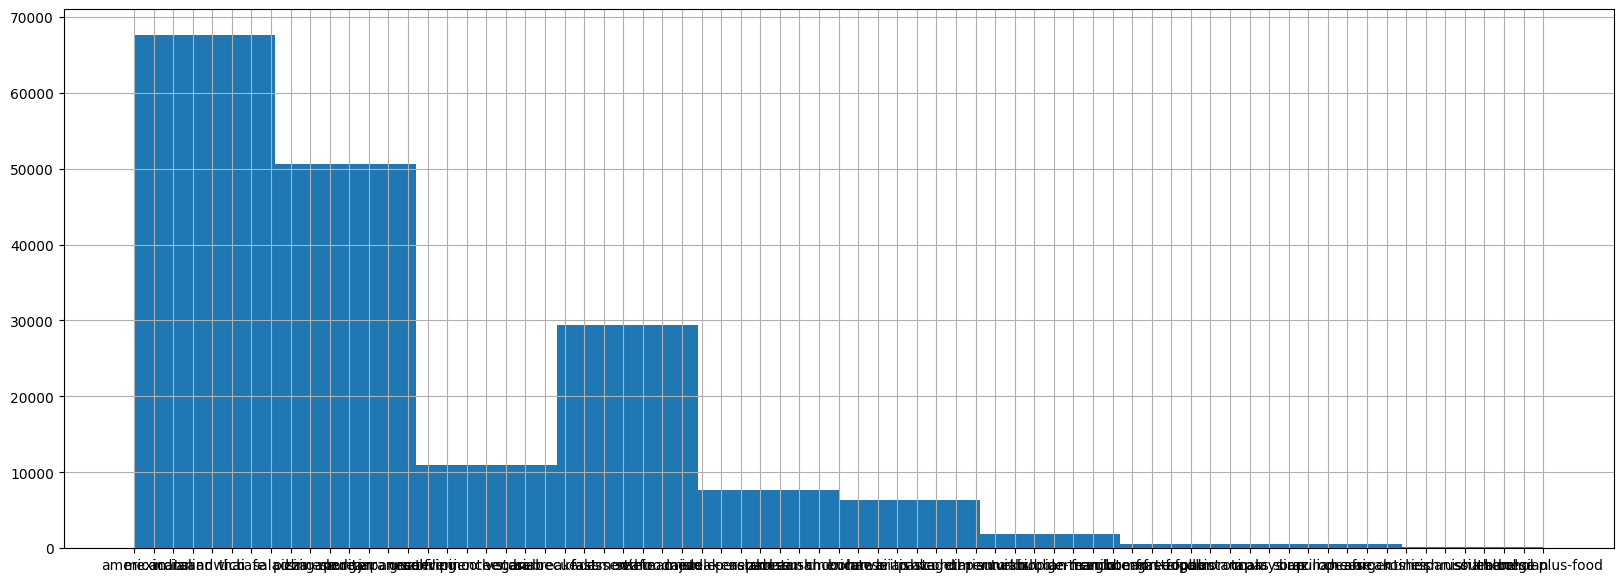

In [36]:
plt.figure(figsize=(20,7))
drop_dash2['store_primary_category'].hist()

In [37]:
drop_dash2.columns

Index(['market_id', 'created_at', 'actual_delivery_time', 'store_id',
       'store_primary_category', 'order_protocol', 'total_items', 'subtotal',
       'num_distinct_items', 'min_item_price', 'max_item_price',
       'total_onshift_dashers', 'total_busy_dashers',
       'total_outstanding_orders', 'estimated_order_place_duration',
       'estimated_store_to_consumer_driving_duration', 'delivery_time'],
      dtype='object')

In [38]:
drop_dash2.total_onshift_dashers.value_counts()

total_onshift_dashers
 0.0      3541
 15.0     2831
 18.0     2830
 21.0     2758
 19.0     2744
          ... 
 164.0       1
 159.0       1
 169.0       1
-4.0         1
 168.0       1
Name: count, Length: 172, dtype: int64

/var/folders/lr/8c5hs04n5c16pwk_y0fr6fvr0000gn/T/ipykernel_18117/2474277577.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  onshift_dashers=drop_dash2.groupby('total_onshift_dashers', group_keys=False).apply(lambda x: x.sample(frac=0.007))
/var/folders/lr/8c5hs04n5c16pwk_y0fr6fvr0000gn/T/ipykernel_18117/2474277577.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  offshift_dashers=drop_dash2.groupby('t

The availability of dashers slightly correlates with the delivery time with onshift at 0.06787577796649426 and busy at 0.08692829554298935


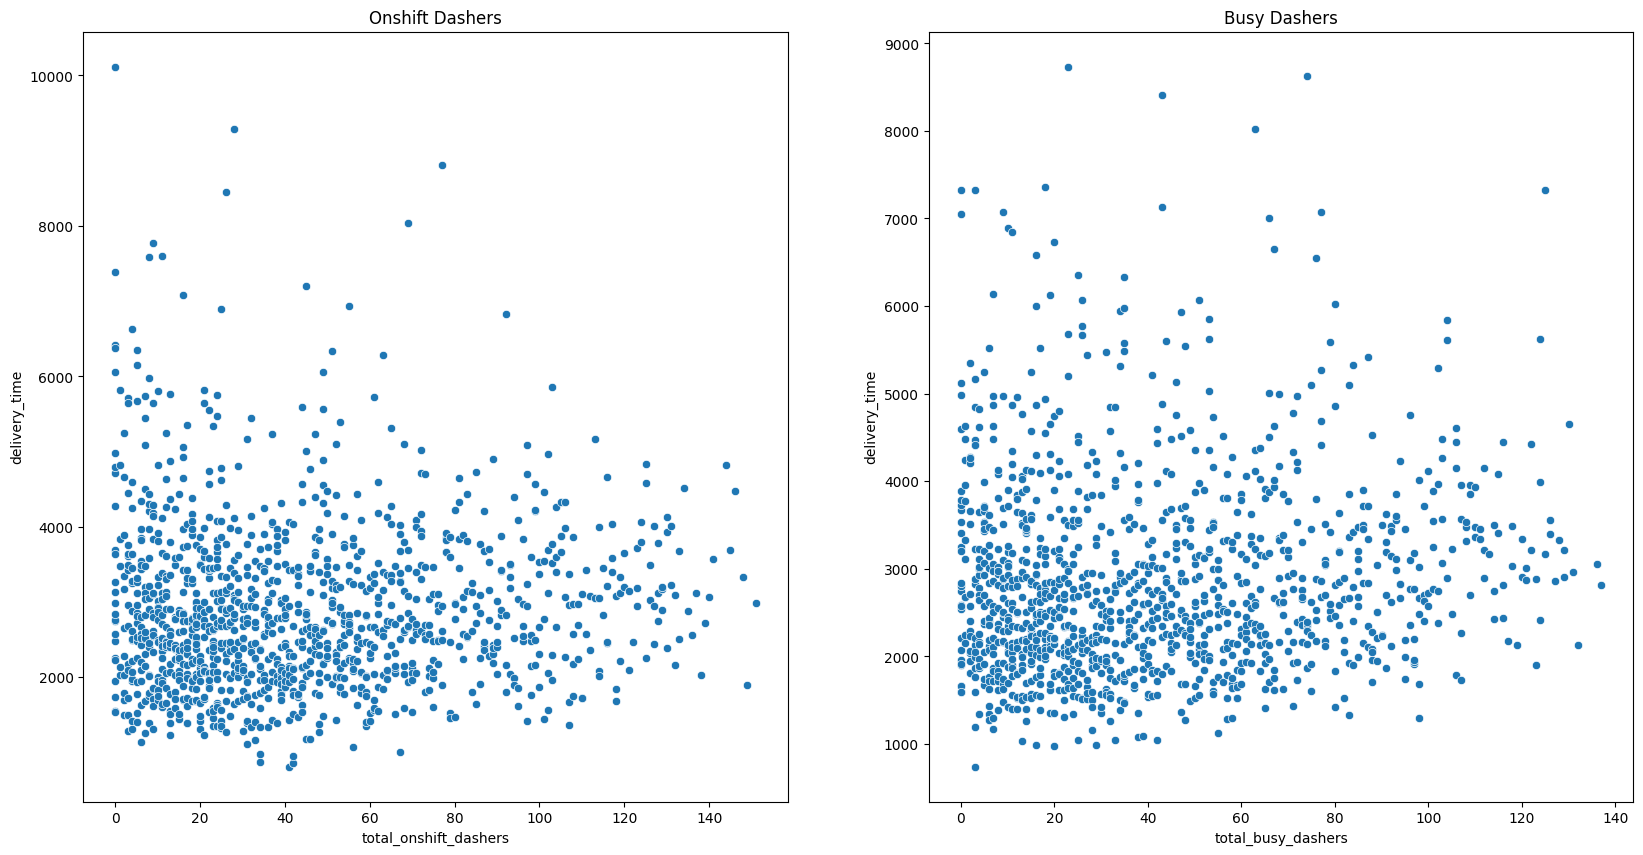

In [39]:
fig, axes = plt.subplots(1, 2,figsize=(20,10))
onshift_dashers=drop_dash2.groupby('total_onshift_dashers', group_keys=False).apply(lambda x: x.sample(frac=0.007))
sns.scatterplot(ax=axes[0],data=onshift_dashers, x="total_onshift_dashers", y="delivery_time")
axes[0].set_title('Onshift Dashers')

offshift_dashers=drop_dash2.groupby('total_busy_dashers', group_keys=False).apply(lambda x: x.sample(frac=0.007))
sns.scatterplot(ax=axes[1],data=offshift_dashers, x="total_busy_dashers", y="delivery_time")
axes[1].set_title('Busy Dashers')

print('The availability of dashers slightly correlates with the delivery time with onshift at {} and busy at {}'.format(drop_dash2.total_onshift_dashers.corr(drop_dash2['delivery_time']),drop_dash2.total_busy_dashers.corr(drop_dash2['delivery_time'])))

/var/folders/lr/8c5hs04n5c16pwk_y0fr6fvr0000gn/T/ipykernel_18117/640365711.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  min_item=drop_dash2.groupby('min_item_price', group_keys=False).apply(lambda x: x.sample(frac=0.007))
/var/folders/lr/8c5hs04n5c16pwk_y0fr6fvr0000gn/T/ipykernel_18117/640365711.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  item_count=drop_dash2.groupby('total_items', group_key

The amount of items seem to differ slightly witha correlation value of 0.10873553452828436 with delivery time as the more items the more time the minimum delviery takes

On the other hand there is little to no relation between min and max item price with 0.013447256402700098 and 0.12561986591539354 respectively



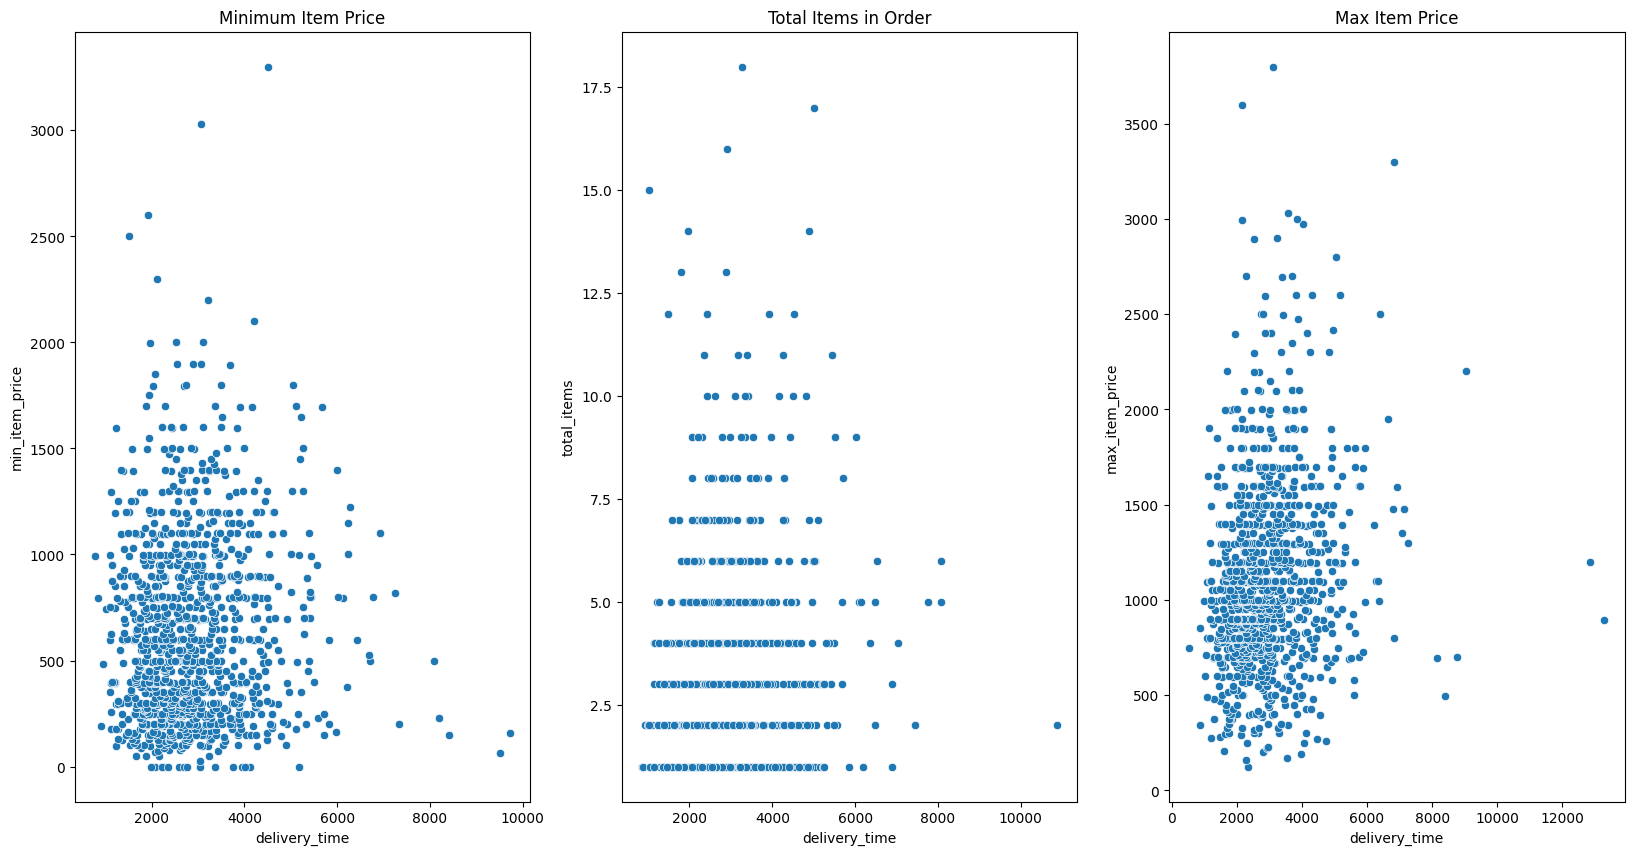

In [40]:
fig, axes = plt.subplots(1, 3,figsize=(20,10))

min_item=drop_dash2.groupby('min_item_price', group_keys=False).apply(lambda x: x.sample(frac=0.007))
sns.scatterplot(ax=axes[0],data=min_item, x="delivery_time", y="min_item_price")
axes[0].set_title('Minimum Item Price')

item_count=drop_dash2.groupby('total_items', group_keys=False).apply(lambda x: x.sample(frac=0.007))
sns.scatterplot(ax=axes[1],data=item_count, x="delivery_time", y="total_items")
axes[1].set_title('Total Items in Order')


max_item=drop_dash2.groupby('max_item_price', group_keys=False).apply(lambda x: x.sample(frac=0.007))
sns.scatterplot(ax=axes[2],data=max_item, x="delivery_time", y="max_item_price")
axes[2].set_title('Max Item Price')

print('The amount of items seem to differ slightly witha correlation value of {} with delivery time as the more items the more time the minimum delviery takes\n'.format(drop_dash2.total_items.corr(drop_dash2['delivery_time'])))
print('On the other hand there is little to no relation between min and max item price with {} and {} respectively\n'.format(drop_dash2.min_item_price.corr(drop_dash2['delivery_time']),drop_dash2.max_item_price.corr(drop_dash2['delivery_time'])))

In [41]:
drop_dash2.groupby('store_primary_category').delivery_time.agg(['min','max','mean']).sort_values(by='mean',ascending=True).head(10)

,min,max,mean
store_primary_category,,,
chocolate,2048.0,2048.0,2048.000000
kosher,1250.0,6347.0,2494.568627
fast,516.0,18809.0,2626.702232
sandwich,223.0,22737.0,2646.382546
turkish,750.0,6676.0,2655.109091
mexican,101.0,38143.0,2660.063968
breakfast,635.0,22512.0,2690.105350
smoothie,386.0,22912.0,2694.986885
alcohol,575.0,39352.0,2710.954728


/var/folders/lr/8c5hs04n5c16pwk_y0fr6fvr0000gn/T/ipykernel_18117/3325102580.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  store_cat=drop_dash2.groupby('store_primary_category', group_keys=False).apply(lambda x: x.sample(frac=0.02)).sort_values(by='delivery_time')


<Axes: xlabel='delivery_time', ylabel='store_primary_category'>

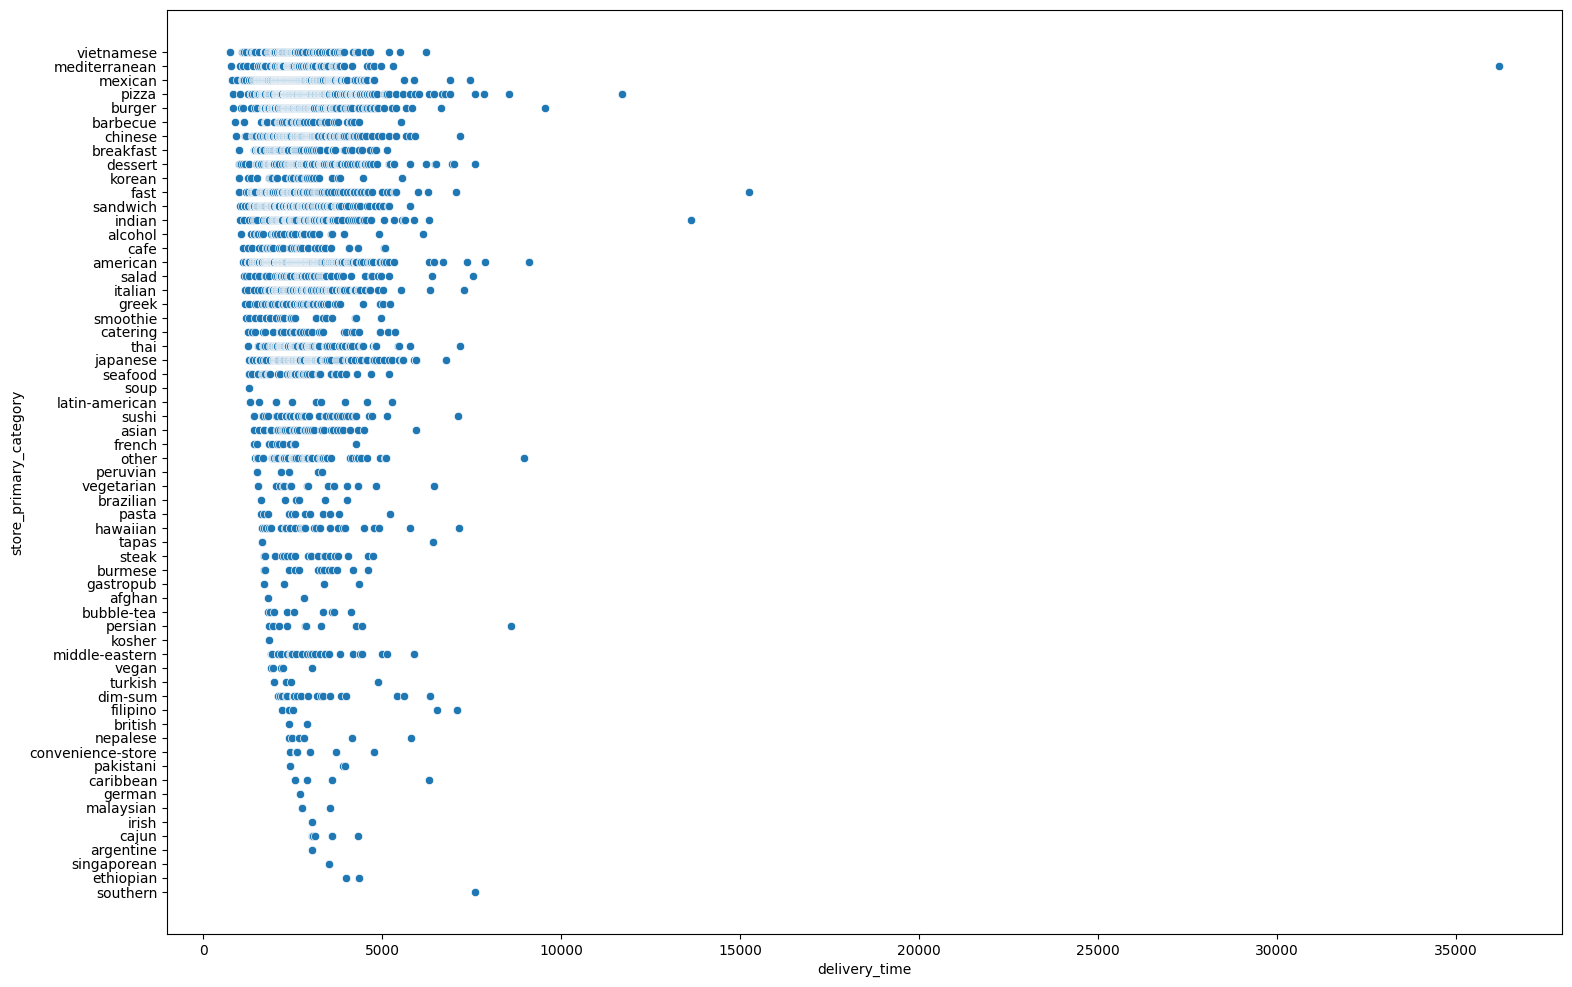

In [42]:
store_cat=drop_dash2.groupby('store_primary_category', group_keys=False).apply(lambda x: x.sample(frac=0.02)).sort_values(by='delivery_time')
plt.figure(figsize=(18,12))
sns.scatterplot(data=store_cat, x="delivery_time", y="store_primary_category")

In [43]:
store=drop_dash2.groupby(['store_id','store_primary_category']).delivery_time.agg(['min','max','mean','count']).sort_values(by=['count','mean'],ascending=False).reset_index()
store.head(10)

,store_id,store_primary_category,min,max,mean,count
0,6865,mexican,297.0,25598.0,2261.345848,879
1,1311,american,862.0,12117.0,2775.830446,808
2,314,mexican,386.0,9062.0,2389.897668,772
3,1686,mexican,626.0,5914.0,2314.695955,717
4,3937,salad,896.0,9070.0,3235.918797,665
5,6917,vietnamese,559.0,7727.0,2555.285486,627
6,6074,sushi,811.0,10515.0,2839.131092,595
7,4367,salad,1010.0,10157.0,3504.571168,548
8,3748,mediterranean,1003.0,9963.0,2947.124521,522
9,6503,dessert,854.0,28279.0,2632.096712,517


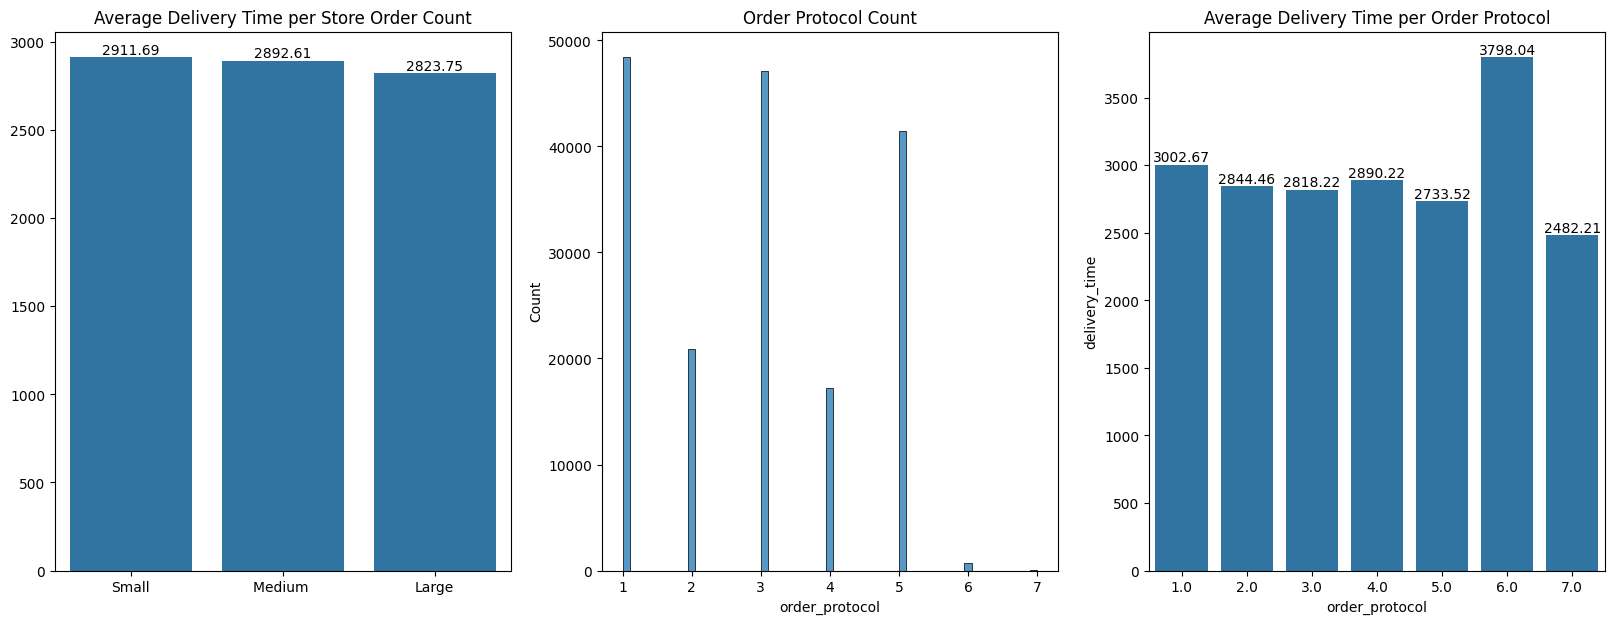

In [44]:
fig, axes = plt.subplots(1, 3,figsize=(20,7))
small=store.loc[store['count']<10]['mean'].mean()
mid=store.loc[(store['count']>10) & (store['count']<400)]['mean'].mean()
large=store.loc[store['count']>400]['mean'].mean()

graph1=sns.barplot(ax=axes[0],x=["Small","Medium ","Large"], y=[small,mid,large])
axes[0].set_title('Average Delivery Time per Store Order Count')
axes[0].ylabel='Average Delivery Time'
axes[0].xlabel='Store order Count'
graph1.bar_label(axes[0].containers[-1])

graph2=sns.histplot(data=drop_dash2, x="order_protocol",ax=axes[1])
axes[1].set_title('Order Protocol Count')


order_proto=drop_dash2.groupby('order_protocol').delivery_time.mean().reset_index()
graph=sns.barplot(ax=axes[2],data=order_proto,x='order_protocol', y='delivery_time')
axes[2].set_title('Average Delivery Time per Order Protocol')
for i in graph.containers:
    axes[2].bar_label(i,)

In [45]:
drop_dash2.columns

Index(['market_id', 'created_at', 'actual_delivery_time', 'store_id',
       'store_primary_category', 'order_protocol', 'total_items', 'subtotal',
       'num_distinct_items', 'min_item_price', 'max_item_price',
       'total_onshift_dashers', 'total_busy_dashers',
       'total_outstanding_orders', 'estimated_order_place_duration',
       'estimated_store_to_consumer_driving_duration', 'delivery_time'],
      dtype='object')

dashers with store id

In [46]:
drop_dash2['total_free_dashers']=drop_dash2['total_onshift_dashers']-drop_dash2['total_busy_dashers']

In [47]:
#storedash=
drop_dash2.groupby(['store_id'])['total_onshift_dashers','total_busy_dashers','total_free_dashers','total_outstanding_orders'].mean().sort_values(by=['total_free_dashers'],ascending=False).head(20)

ValueError: Cannot subset columns with a tuple with more than one element. Use a list instead.

<AxesSubplot:xlabel='estimated_store_to_consumer_driving_duration', ylabel='delivery_time'>

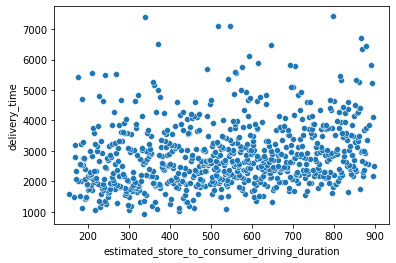

In [ ]:
driving=drop_dash2.groupby('estimated_store_to_consumer_driving_duration', group_keys=False).apply(lambda x: x.sample(frac=0.005)).sort_values(by='delivery_time')
sns.scatterplot(data=driving, x="estimated_store_to_consumer_driving_duration", y="delivery_time")

In [ ]:
cor=drop_dash2.corr().reset_index()
cor[['index','delivery_time']].sort_values(by='delivery_time',ascending=False)

,index,delivery_time
13,delivery_time,1.000000
12,estimated_store_to_consumer_driving_duration,0.222443
4,subtotal,0.201811
10,total_outstanding_orders,0.172723
5,num_distinct_items,0.147861
7,max_item_price,0.125620
3,total_items,0.108736
11,estimated_order_place_duration,0.098685
9,total_busy_dashers,0.086928
8,total_onshift_dashers,0.067876


In [ ]:
drop_dash3=drop_dash2.copy()
drop_dash3=drop_dash3.drop(['created_at','actual_delivery_time'],axis=1)

In [ ]:
scaler=StandardScaler()
drop_dash3_scaled=pd.DataFrame(preprocessing.scale(drop_dash3.loc[:, drop_dash3.columns != 'store_primary_category']),columns=drop_dash3.loc[:, drop_dash3.columns != 'store_primary_category'].columns)
drop_dash3_dummied=pd.get_dummies(drop_dash3['store_primary_category'])
frames = [drop_dash3_scaled, drop_dash3_dummied]
drop_dash3 = pd.concat(frames,axis=1)
drop_dash3

,market_id,store_id,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,...,southern,spanish,steak,sushi,tapas,thai,turkish,vegan,vegetarian,vietnamese
0,-1.310128,-0.832363,-1.263447,0.297311,0.406819,0.815009,-0.246143,0.140581,-0.345022,-0.866110,...,0,0,0,0,0,0,0,0,0,0
1,-0.558790,0.934214,-0.602563,-0.824584,-0.435925,-1.030377,1.375380,0.427657,-1.271360,-1.239147,...,0,0,0,0,0,0,0,0,0,0
2,-0.558790,0.934214,0.058322,0.297311,1.134171,0.199880,0.259741,0.791405,-1.068724,-1.114801,...,0,0,0,0,0,0,0,0,0,0
3,-1.310128,-0.347916,-1.263447,-0.824584,-0.641006,-1.030377,1.615819,0.650542,-1.155568,-1.114801,...,0,0,0,0,0,0,0,0,0,0
4,-1.310128,-0.347916,-1.263447,-0.450619,0.504711,-0.415249,1.423468,1.845206,-1.155568,-1.145887,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175772,-1.310128,-0.291981,0.719206,-0.076654,-0.715382,0.199880,-0.653929,-0.911437,-0.808191,-0.772851,...,0,0,0,0,0,0,0,0,0,0
175773,-1.310128,-0.291981,0.719206,1.045241,0.171113,0.815009,-0.538518,-0.597615,-0.952932,-0.959369,...,0,0,0,0,0,0,0,0,0,0
175774,-1.310128,-0.291981,0.719206,0.671276,-0.470926,0.199880,-0.740487,-1.357208,-0.171334,-0.026777,...,0,0,0,0,0,0,0,0,0,0
175775,-1.310128,0.035847,-1.263447,-0.824584,-0.832414,-1.030377,-0.288461,-1.114709,-1.097672,-1.083715,...,0,0,0,0,0,0,0,0,0,0


## Model Building</p>
### Steps involved in Model Building
* Split test and training sets
* Fit models to data
* Find model with best mean squared error and R2 score
* Hyperparameter tuning using GridSearch CV
* Fitting the final model 

In [ ]:
#X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=0)
pipe = Pipeline(steps=[('scaler', StandardScaler()),('One Hot Encoding',OneHotEncoder())])

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
from sklearn.preprocessing import PolynomialFeatures
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

def predictmodels(clf_A,clf_B,clf_C,X,y):
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)
  print("Training set has {} samples.".format(X_train.shape[0]))
  print("Testing set has {} samples.".format(X_test.shape[0]))
  print()
  results = {}
  df = pd.DataFrame()
  for clf in [clf_A, clf_B, clf_C]:
      clf_name = clf.__class__.__name__
      results[clf_name] = {}
      results[clf_name] = \
      clf = clf.fit(X_train, y_train)
      try:
        predictions_test = clf.predict(X_test)
      except:
        predictions_test = clf_A.predict(X_test)
     # print(clf)
     # print("MSE",mean_squared_error(y_test,predictions_test))
     # print("RMSE",np.sqrt(mean_squared_error(y_test,predictions_test)))
     # print("R2",r2_score(y_test,predictions_test))
     # print()
      row={'MSE':mean_squared_error(y_test,predictions_test),'RMSE':np.sqrt(mean_squared_error(y_test,predictions_test)),'R2':r2_score(y_test,predictions_test)}
      rows=[mean_squared_error(y_test,predictions_test),np.sqrt(mean_squared_error(y_test,predictions_test)),r2_score(y_test,predictions_test)]
      d = {clf_name: row}
      if df.empty:
        df=pd.DataFrame(data=d)
      else:
        df[clf_name]=rows
  return df


In [ ]:
X=drop_dash3
y=drop_dash3['delivery_time']
X=X.drop(columns=["delivery_time",'market_id'])
predictmodels(LinearRegression(),linear_model.Lasso(random_state=3),PolynomialFeatures(),X,y)

Training set has 140621 samples.
Testing set has 35156 samples.



,LinearRegression,Lasso,PolynomialFeatures
MSE,0.715874,9.211710e-01,0.715874
R2,0.222865,9.597766e-01,0.846093
RMSE,0.846093,-7.020322e-08,0.222865


In [ ]:
predictmodels(DecisionTreeRegressor(random_state=3),RandomForestRegressor(random_state=3),linear_model.BayesianRidge(),X,y)

Training set has 140621 samples.
Testing set has 35156 samples.



,DecisionTreeRegressor,RandomForestRegressor,BayesianRidge
MSE,1.435026,0.695098,0.715741
R2,-0.557828,0.833725,0.846015
RMSE,1.197926,0.245419,0.223010
